# Comparisons of Book clubs based on GoodReads data

This notebooks contains code to analyse the differences and similarities between te books selected by three book clubs:


* Reese's Book Club x Hello Sunshine
* Oprah's Book Club
* Read with Jenna

The comparative analysis focuses on the genres, the nationalities of authors and the average ratings of the books, among other aspects. 

In [97]:
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import re
import os
import random
from tqdm import tqdm
from os.path import basename
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import time

from urllib.parse import urlparse
from urllib.parse import parse_qs
# Import Module
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'
]

def select_agent():
    n=random.randint(0,len(user_agents)-1)
    return user_agents[n]

key = 'QypW6JzQ4XfGViss1Ks4g'

The cell below defines a function that can be used to extract data about individual books. The function demands either an ISBN or a goodReads ID as an input value. 

In [ ]:
def get_book_data(book_id,id_type='isbn'):
 

    row = dict()
    
    authors = []
    genres = []
        
    if id_type=='goodreads': 
        goodreads_id = book_id
        url = f'https://www.goodreads.com/book/show.xml?key={key}&id={book_id}'
    else:
        url = f'https://www.goodreads.com/book/isbn/{book_id}?format=xml&key=QypW6JzQ4XfGViss1Ks4g'
        

    headers = {'User-Agent': select_agent() }
    response = requests.get( url, headers=headers)

    if response:
        xml_data = response.text

        root = ET.fromstring(xml_data)
        book = root.find('book')
        goodreads_id = book.find('id').text
        isbn13 = book.find('isbn13').text
        title = book.find('title').text

        publication_year = book.find('publication_year').text
        publisher = book.find('publisher').text
        language_code = book.find('language_code').text
        description = book.find('description').text
        average_rating = book.find('average_rating').text
        num_pages = book.find('num_pages').text
        text_reviews_count = book.find('text_reviews_count').text

        authors_el = book.findall('authors/author')
        for a in authors_el:
            authors.append( {'id':a.find('id').text , 'name':a.find('name').text } )

        row['authors'] = authors

        row['book_id'] = goodreads_id
        row['isbn13' ] = isbn13
        row['title'] = title
        row['publication_year'] = publication_year
        row['publisher'] = publisher
        row['language_code'] = language_code
        row['description'] = description
        row['average_rating'] = float(average_rating)
        if num_pages is not None:
            row['num_pages'] = int(num_pages)

    url = f'https://www.goodreads.com/book/show/{goodreads_id}'

    headers = {'User-Agent': select_agent() }
    response = requests.get( url, headers=headers)


    if response:
        html_page = response.text
        soup = BeautifulSoup(html_page, "lxml")
        ul_genres = soup.find('ul',{'aria-label':"Top genres for this book"})
    
        if ul_genres is not None:
            genres_el = ul_genres.findAll('span', {'class':'Button__labelItem'})
            for g in genres_el:
                if not re.search( r'more' , g.text ):
                    genres.append(g.text)

            row['genres'] = genres

        ratings_el = soup.find('span',{'data-testid':"ratingsCount"})
        if ratings_el is not None:
            ratings = ratings_el.text
            ratings = int(re.sub(r'\D','',ratings))
            row['ratings'] = ratings
        reviews_el = soup.find('span',{'data-testid':"reviewsCount"})
        if reviews_el is not None:
            reviews = reviews_el.text
            reviews = int(re.sub(r'\D','',reviews))
            row['reviews'] = reviews

    return row


## Reese's Book Club x Hello Sunshine

As a first step, we collect data about [the books selected by Reese's Book Club](https://reesesbookclub.com/article/4eRlfCOXueqPrm6ZnQpzwl). The ISBNs are extracted from the web page listin the various books. 

In [ ]:
## Overview page with all the titles
url = 'https://reesesbookclub.com/article/4eRlfCOXueqPrm6ZnQpzwl'

response = requests.get(url)
if response:
    html_page = response.text
    soup = BeautifulSoup(html_page, "lxml")
    
    hyperlinks = soup.findAll('a')
    rbc_isbns = []

    for a in hyperlinks:
        if re.search( r'bookshop' , a.get('href').lower() ):
            isbn = basename(a.get('href'))
            rbc_isbns.append(isbn)

We subsequently request data about these books from the goodReads database using the function that was defined above. The results is saved in a file named '[reese.json](https://raw.githubusercontent.com/peterverhaar/dath_notebooks/main/goodReads/reese.json)'

In [ ]:
data = []
for isbn in rbc_isbns:
    row = get_book_data(isbn)
    data.append(row)
    
json_object = json.dumps(data, indent = 4) 
with open('reese.json','w',encoding='utf-8') as out:
    out.write(json_object)

## Oprah's Book Club

The same steps are carried out for the books selected by Oprah's Book Club. The goodReads IDs are extracted from [the official bookshelf of the book club on goodReads](https://www.goodreads.com/group/bookshelf/85538-oprah-s-book-club-official). 

In [ ]:
book_ids = []

for i in [1,2]:

    url = f'https://www.goodreads.com/group/bookshelf/85538-oprah-s-book-club-official?utf8=%E2%9C%93&page={i}&per_page=100'
    print(url)
    
    headers = {'User-Agent': select_agent() }
    response = requests.get( url, headers=headers)

    if response:
        html_page = response.text
        soup = BeautifulSoup(html_page, "lxml")

        links = soup.find_all('a')

        for a in links:
            if a.get('href'):
                if re.search( r'^\/book\/show/' , a.get('href')):
                    url = a.get('href')
                    url = re.sub( r'\/book\/show\/' , '' , url )
                    book_id = ''
                    if re.search('[-]',url):
                        book_id = url[:url.index('-')]
                    elif re.search('[.]',url):
                        book_id = url[:url.index('.')]
                    if len(book_id)>0:
                        book_ids.append(book_id)
                    
                                 
book_ids = list(set(book_ids))          


As alternative method, we can select ISBNs from the [Oprah Book Club website](https://www.oprah.com/book/oprahs-book-club-long-island-by-colm-toibin?editors_pick_id=26790). This second method is ineffecive, however, since the web pages for the indivual books often lack ISBNs.  

In [ ]:
oprah_isbns = []
count = 0

next_page = 'https://www.oprah.com/book/oprahs-book-club-long-island-by-colm-toibin?editors_pick_id=26790'

while re.search( r'\w+' , next_page ):


    response = requests.get( next_page, headers=headers)
    if response:
        html_page = response.text
        soup = BeautifulSoup(html_page, "lxml")
        book_sellers = soup.find('div' , {'id':'book_sellers'})
        try:
            buy_links = book_sellers.findAll('a')
            for a in buy_links:
                if re.search( r'EAN=' , a.get('href') , re.IGNORECASE ):
                    parsed_url = urlparse(a.get('href'))
                    isbn = parse_qs(parsed_url.query)['EAN'][0]
                    oprah_isbns.append(isbn)
        except:
            print(f'No ISBN found for {next_page}')

        next_page = '' 
        next = soup.find('a',{'class':'articleslide-next'})
        next_page = next.get('href')
        print(next_page)

The data found (using the first method that was mentioned) are saved in a file named '[oprah.json](https://raw.githubusercontent.com/peterverhaar/dath_notebooks/main/goodReads/oprah.json)'

In [ ]:
book_ids = list(set(book_ids))
print(len(book_ids))

data = []
for isbn in book_ids:
    row = get_book_data(isbn,'goodreads')
    data.append(row)
    
json_object = json.dumps(data, indent = 4) 
with open('oprah.json','w',encoding='utf-8') as out:
    out.write(json_object)


## Read with Jenna

a similar procedure is followed to collect the ISBNs of the books selected by the "read with Jenna" bookclub. The books are listed on [the bookclub's web page](https://www.today.com/shop/read-with-jenna). 

In [ ]:
url = 'https://www.today.com/shop/read-with-jenna'

response = requests.get(url)
if response:
    html_page = response.text
    soup = BeautifulSoup(html_page, "lxml")
    hyperlinks = soup.findAll('a' , {'class':'db'})
    
    bookshop_urls = []

    for url in hyperlinks:
        url = url.get('href')

        if re.search('urllink',url):
                parsed_url = urlparse(url)
                captured_value = parse_qs(parsed_url.query)['urllink'][0]
                bookshop_url = f"https://{captured_value}"
                bookshop_urls.append(bookshop_url)

bookshop_urls = list(set(bookshop_urls))
print(f'{len(bookshop_urls)} books were found.')

In [ ]:
## The bookshop pages are best parsed using Selenium 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

all_isbns = []
 
# Open Chrome
path = 'chromedriver-mac-arm64/chromedriver'

for url in bookshop_urls:
    isbn = os.path.basename(url)
    if len(isbn)> 12:
        if isbn not in all_isbns:
            all_isbns.append(isbn)
    else:
        try:
            driver = webdriver.Chrome(path)
            driver.get(url)
            xpath = '//div[@itemprop="isbn"]'
            isbn = driver.find_element(by=By.XPATH, value=xpath)
            all_isbns.append(isbn.text)
            #driver.close()
            driver.quit() 
        except:
            print(f'Problem for {url}')

The results are saved in a file named '[jenna.json](https://raw.githubusercontent.com/peterverhaar/dath_notebooks/main/goodReads/jenna.json)'

In [ ]:
all_isbns = [isbn.strip() for isbn in all_isbns]

data = []
for isbn in all_isbns:
    row = get_book_data(isbn)
    data.append(row)
    
json_object = json.dumps(data, indent = 4) 
with open('jenna.json','w',encoding='utf-8') as out:
    out.write(json_object)

## Comparative Analysis of the book collections. 

In [16]:
json_file = open('reese.json',encoding='utf-8')
reese = json.load(json_file)

json_file = open('oprah.json',encoding='utf-8')
oprah = json.load(json_file)

json_file = open('jenna.json',encoding='utf-8')
jenna = json.load(json_file)

### Genres

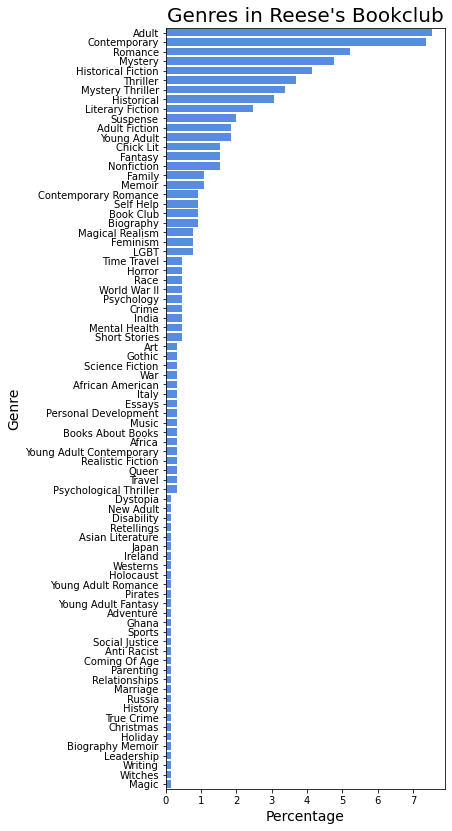

In [22]:
genres_reese = Counter()
for book in reese:
    if 'genres' in book:
        genres_reese.update(book['genres'])

total = sum(genres_reese.values())

x_axis = []
y_axis = []

for genre,count in genres_reese.most_common():
    if genre != 'Audiobook' and genre != 'Fiction':
        y_axis.append(genre)
        x_axis.append( (count/total)*100 )
    

fig = plt.figure( figsize=(5,14) )


graph = sns.barplot(  x=x_axis, y=y_axis, color = '#4287f5')

graph.set_title('Genres in Reese\'s Bookclub', size = 20) 
graph.set_xlabel('Percentage' , size = 14) 
graph.set_ylabel('Genre' , size = 14 )

plt.show()

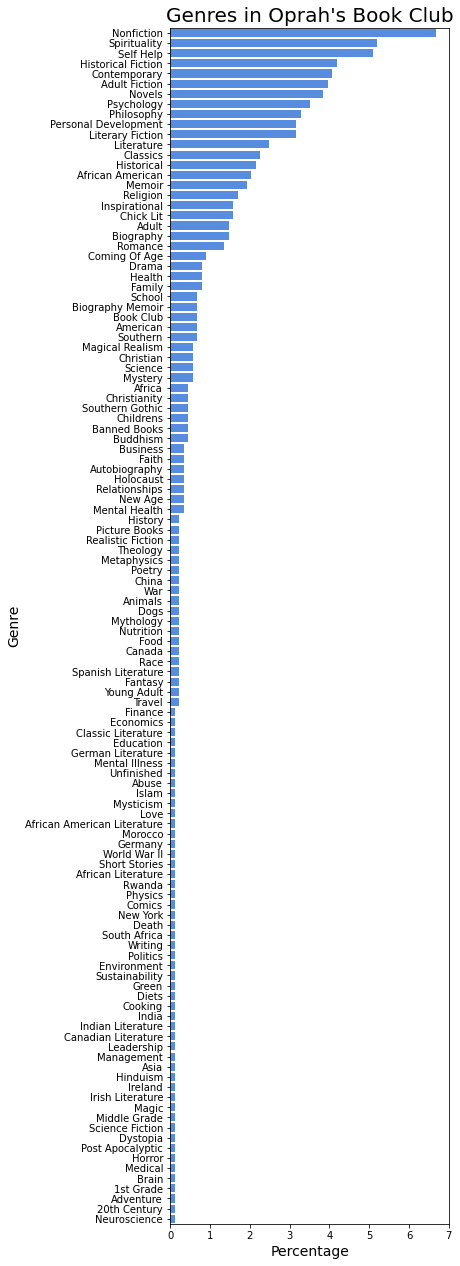

In [23]:
genres_oprah = Counter()
for book in oprah:
    if 'genres' in book:
        genres_oprah.update(book['genres'])

total = sum(genres_oprah.values())

x_axis = []
y_axis = []

for genre,count in genres_oprah.most_common():
    if genre != 'Audiobook' and genre != 'Fiction':
        y_axis.append(genre)
        x_axis.append( (count/total)*100 )
    

fig = plt.figure( figsize=(5,22) )


graph = sns.barplot(  x=x_axis, y=y_axis, color = '#4287f5')

graph.set_title('Genres in Oprah\'s Book Club' , size = 20) 
graph.set_xlabel('Percentage' , size = 14) 
graph.set_ylabel('Genre' , size = 14 )

plt.show()

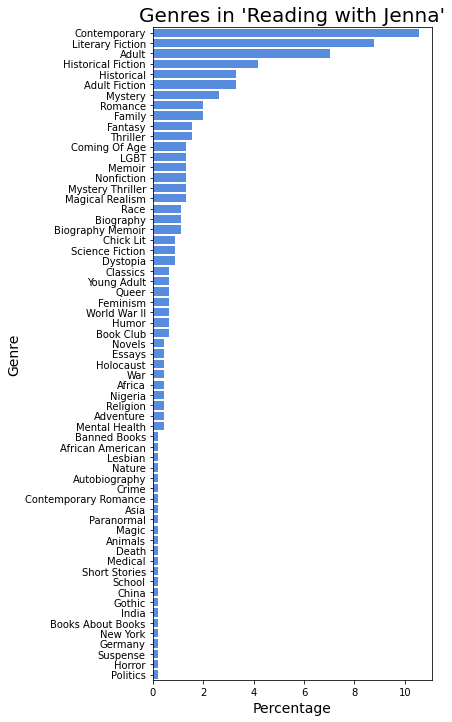

In [24]:
genres_jenna = Counter()
for book in jenna:
    if 'genres' in book:
        genres_jenna.update(book['genres'])

total = sum(genres_jenna.values())

x_axis = []
y_axis = []

for genre,count in genres_jenna.most_common():
    if genre != 'Audiobook' and genre != 'Fiction':
        y_axis.append(genre)
        x_axis.append( (count/total)*100 )
    

fig = plt.figure( figsize=(5,12) )


graph = sns.barplot(  x=x_axis, y=y_axis, color = '#4287f5')

graph.set_title('Genres in \'Reading with Jenna\'' , size = 20) 
graph.set_xlabel('Percentage' , size = 14) 
graph.set_ylabel('Genre' , size = 14 )

plt.show()

Which genres are unique to the titles in Reese's book club?

In [33]:
unique = []
for genre in genres_reese.keys():
    if genre not in genres_oprah.keys() and genre not in genres_jenna.keys():
        unique.append(genre)
        
print(', '.join(unique))

Art, Time Travel, Italy, Music, New Adult, Disability, Retellings, Asian Literature, Japan, Young Adult Contemporary, Westerns, Young Adult Romance, Pirates, Young Adult Fantasy, Ghana, Sports, Social Justice, Anti Racist, Parenting, Marriage, Russia, True Crime, Christmas, Holiday, Psychological Thriller, Witches


Which genres are unique to the titles in Oprah's book club?

In [26]:
unique = []
for genre in genres_oprah.keys():
    if genre not in genres_reese.keys() and genre not in genres_jenna.keys():
        unique.append(genre)
        
print(', '.join(unique))

Inspirational, Finance, Business, Economics, Literature, Classic Literature, Spirituality, Philosophy, Christian, Faith, Education, Science, Drama, Christianity, German Literature, Health, New Age, American, Mental Illness, Southern Gothic, Unfinished, Abuse, Childrens, Picture Books, Islam, Mysticism, Theology, Southern, Love, Buddhism, African American Literature, Morocco, Metaphysics, Poetry, African Literature, Rwanda, Physics, Comics, Dogs, South Africa, Mythology, Environment, Sustainability, Green, Nutrition, Food, Diets, Cooking, Indian Literature, Canada, Canadian Literature, Management, Hinduism, Spanish Literature, Irish Literature, Middle Grade, Post Apocalyptic, Brain, 1st Grade, 20th Century, Neuroscience


Which genres are unique to the titles selected by 'Reading with Jenna'?

In [34]:
unique = []
for genre in genres_jenna.keys():
    if genre not in genres_reese.keys() and genre not in genres_oprah.keys():
        unique.append(genre)
        
print(', '.join(unique))

Lesbian, Nature, Nigeria, Humor, Paranormal


## Comparison of ratings and reviews

In [37]:
def get_data(field,json):
    if field in json:
        return json[field]
    else:
        return numpy.nan

data = []

for book in reese:
    row = []
    row.append(get_data('ratings',book))
    row.append(get_data('reviews',book))
    row.append(get_data('average_rating',book))
    row.append(get_data('num_pages',book))
    row.append(get_data('title',book))
    row.append('Reese')
    data.append(row)

for book in oprah:
    row = []
    row.append(get_data('ratings',book))
    row.append(get_data('reviews',book))
    row.append(get_data('average_rating',book))
    row.append(get_data('num_pages',book))
    row.append(get_data('title',book))
    row.append('Oprah')
    data.append(row)
    
for book in jenna:
    row = []
    row.append(get_data('ratings',book))
    row.append(get_data('reviews',book))
    row.append(get_data('average_rating',book))
    row.append(get_data('num_pages',book))
    row.append(get_data('title',book))
    row.append('Jenna')
    data.append(row)
        
df = pd.DataFrame(data,columns=['ratings','reviews','average_rating','num_pages','title','group'])

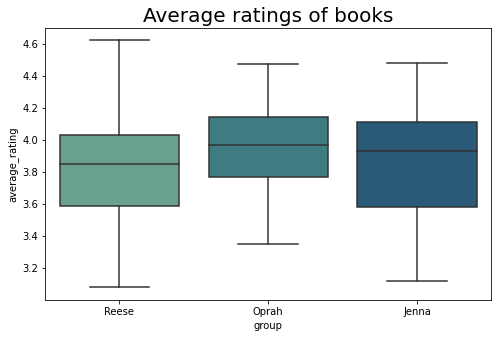

In [40]:
fig = plt.figure( figsize = ( 8, 5))
 
graph = sns.boxplot(data=df,x='group',y='average_rating',palette='crest')
graph.set_title('Average ratings of books' , size = 20) 

plt.show()

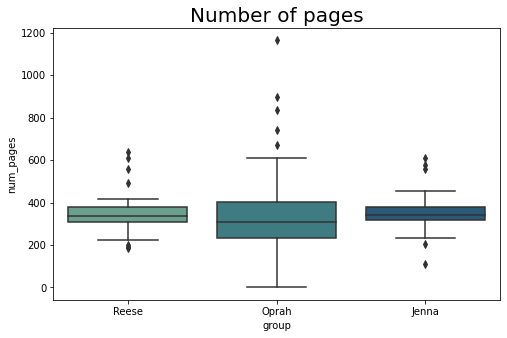

In [41]:
fig = plt.figure( figsize = ( 8, 5))
 
graph = sns.boxplot(data=df,x='group',y='num_pages',palette='crest')
graph.set_title('Number of pages' , size = 20) 

plt.show()

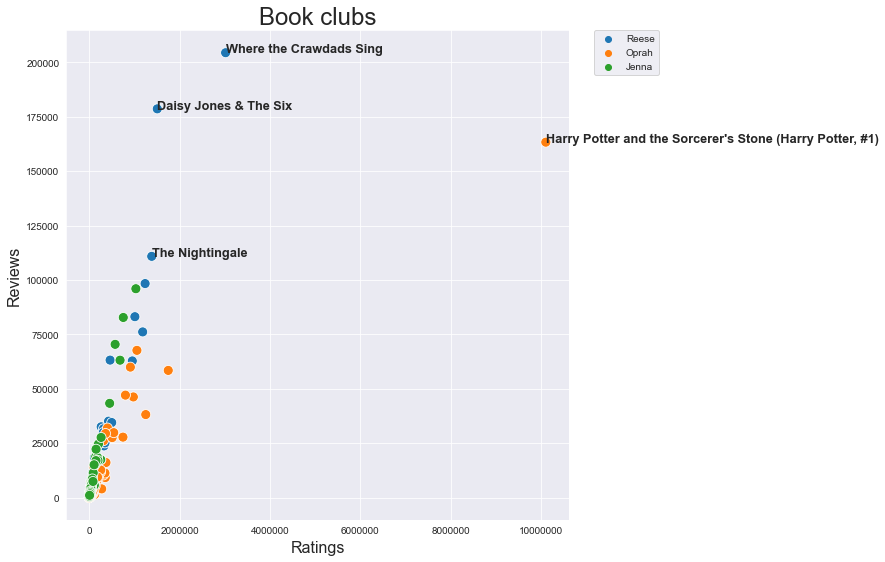

In [42]:
sns.set_style("darkgrid")

fig=plt.figure( figsize = ( 9,9 ))

x_axis = 'ratings'
y_axis = 'reviews'

g = sns.scatterplot( data = df , x = x_axis , y = y_axis , hue='group' , s = 100 ) 
plt.ticklabel_format(style='plain', axis='x')

for index, row in df.iterrows():
    if row[y_axis] > 100000:
        plt.text( row[x_axis],row[y_axis],row['title'], 
                 fontsize=12.8,  
                  weight='semibold')

plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

g.set_xlabel('Ratings',fontsize = 16 )
g.set_ylabel('Reviews',fontsize = 16 )
g.set_title('Book clubs',fontsize=24 )

plt.show()

In [45]:
book_ids = []
authors = []

for book in reese:
    if 'book_id' in book:
        book_ids.append(book['book_id'])
        for author in book['authors']:
            authors.append(author['id'])

for book in oprah:
    if 'book_id' in book:
        book_ids.append(book['book_id'])
        for author in book['authors']:
            authors.append(author['id'])
    
for book in jenna:
    if 'book_id' in book:
        book_ids.append(book['book_id'])
        for author in book['authors']:
            authors.append(author['id'])
            
count_authors = Counter(authors)          

Have any of the book clubs focused on the same titles, or are all the titles in these collections unique?

In [44]:
books_on_more_lists = []

book_count = Counter(book_ids)
for book,count in book_count.most_common():
    if count>1:
        print(f'Book with id {book} occurs on the lists of {count} groups.')
        print(f'https://www.goodreads.com/book/show/{book}')
        books_on_more_lists.append(book)
        
if len(books_on_more_lists)==0:
    print('There is no overlap between the various groups.')

There is no overlap between the various groups.


## Analysis of the authors

The code below collects data about the authors of the books using goodRead's [https://www.goodreads.com/author/show.xml](https://www.goodreads.com/author/show.xml) API. The results are saved in a file named '[authors.json](https://raw.githubusercontent.com/peterverhaar/dath_notebooks/main/goodReads/authors.json)'.

In [98]:
## Mapbox API for some reason returns 
## incorrect countries for locations below.
location_country = {
'New York':'United States',
'Charleston':'United States',
'Elizabeth':'United States',
'San Diego':'United States',
'Texas':'United States',
'Massachusetts':'United States',
'New Jersey':'United States',
'Edinburgh':'United Kingdom',
'North Carolina':'United States',
'New York, New York':'United States',
'Sighet, Kingdom of Romania':'Romania',
'Cincinnati':'United States'}

data = []
for author,count in tqdm(count_authors.most_common()):
    author_id = author

    url = f'https://www.goodreads.com/author/show.xml?id={author}&key={key}'

    headers = {'User-Agent': select_agent() }
    response = requests.get( url, headers=headers)

    if response:
        row = dict()
        xml_data = response.text
        root = ET.fromstring(xml_data)
        author = root.find('author')
        name = author.find('name').text
        
        row['id'] = author_id
        row['name'] = name
        
        fans_count = author.find('fans_count').text
        row['fans_count'] = fans_count
        
        works_count = author.find('works_count').text
        row['works_count'] = works_count
        
        hometown = author.find('hometown').text
        
        
        if hometown:
            row['hometown'] = hometown
            
            url_gis = f'https://api.mapbox.com/search/searchbox/v1/suggest?q={hometown}&access_token=pk.eyJ1IjoicGV0ZXJ2ZXJoYWFyIiwiYSI6ImNqdHhtbDBnMjAzY2szenRiYWZ5ZGNobGoifQ.AD1E8CCCaEMrPYMjgLq0gg&session_token=eJwrLkrWTyzI1M9IzEvJSS0q1i9LzMlMSSxJ1Ssq1jU1BgC8EgtT'
            time.sleep(1)

            response_gis = requests.get( url_gis )
            json_data = response_gis.json()

            country = ''
            
            if hometown in location_country:
                country = location_country[hometown]
            else:            
                try:
                    country = json_data['suggestions'][0]['context']['country']['name']
                    row['country'] = country
                except:
                    print(f'Problem for {hometown}')
            born_at = author.find('born_at').text
            
        if born_at is not None:
            birth_year = born_at[:4]
            row['birth_year'] = birth_year
                
        data.append(row)

        

100%|█████████████████████████████████████████| 277/277 [06:50<00:00,  1.48s/it]


In [99]:
json_object = json.dumps(data, indent = 4) 
with open('authors.json','w',encoding='utf-8') as out:
    out.write(json_object)

In [147]:

json_file = open('authors.json',encoding='utf-8')
authors_json = json.load(json_file)

    
# variable to link author data to author ID
authors_dict = dict()

for author in authors_json:

    author_id = get_value('id',author)
    name = get_value('name',author)
    if 'country' in author:
        country = author['country']
    else:
        country = numpy.nan
    birth_year = get_value('birth_year',author)

    authors_dict[author_id] = [country,birth_year,name]
    

## Nationalities and ages of authors in Reese's bookclub

In [102]:
def get_value(field,json):
    if field in json:
        return json[field]
    else:
        return numpy.nan

In [112]:
countries = []
birth_years = []

for book in reese:
    authors = get_value('authors',book)
    if len(authors)>0:
        author = authors[0]['id']
        
        if authors_dict.get(author)[0] is not None:
            countries.append(authors_dict.get(author)[0])
        if authors_dict.get(author)[1] is not None:
            birth_years.append(authors_dict[author][1])
    

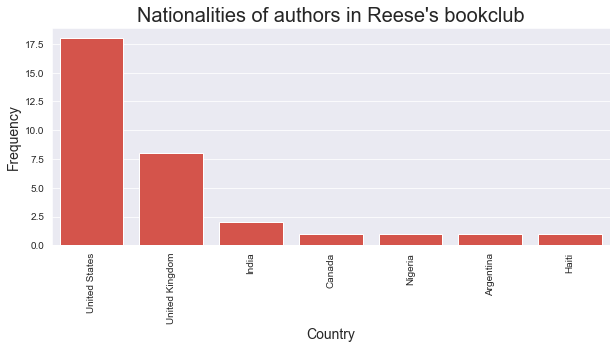

In [113]:
country_count = Counter(countries)

import matplotlib.pyplot as plt
import seaborn as sns

x_axis = list(country_count.keys())
y_axis = list(country_count.values())

fig = plt.figure( figsize=( 10 , 4 ) )


graph = sns.barplot( x=x_axis, y=y_axis, color='#eb4034' )

graph.set_title('Nationalities of authors in Reese\'s bookclub' , size = 20) 
graph.set_xlabel('Country' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )

plt.xticks(rotation= 90)
# The next line places the legend outside out the plot

plt.show()


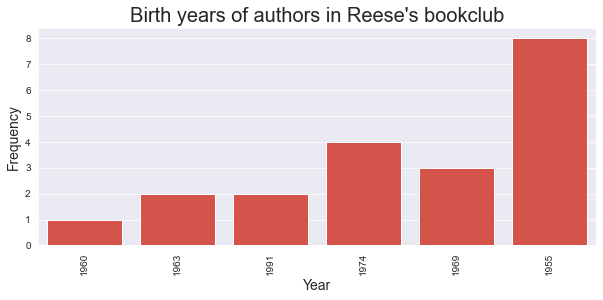

In [114]:
year_count = Counter(birth_years)

import matplotlib.pyplot as plt
import seaborn as sns

x_axis = list(year_count.keys())
y_axis = list(year_count.values())

fig = plt.figure( figsize=( 10 , 4 ) )


graph = sns.barplot( x=x_axis, y=y_axis, color='#eb4034' )

graph.set_title('Birth years of authors in Reese\'s bookclub' , size = 20) 
graph.set_xlabel('Year' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )

plt.xticks(rotation= 90)
# The next line places the legend outside out the plot

plt.show()


In [140]:
countries = []
birth_years = []

for book in oprah:
    
    if len(book)>0:
        authors = get_value('authors',book)
        if authors:
            author = authors[0]['id']
            countries.append(authors_dict[author][0])
            birth_years.append(authors_dict[author][1])


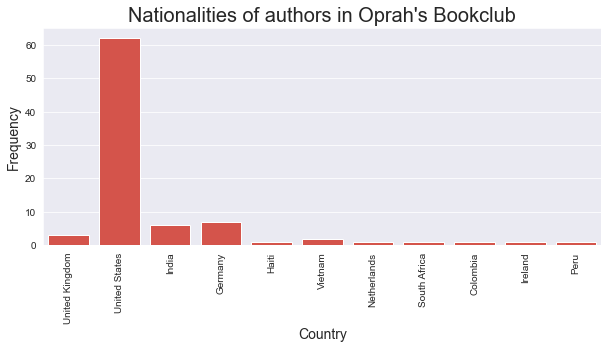

In [141]:
country_count = Counter(countries)

x_axis = list(country_count.keys())
y_axis = list(country_count.values())

fig = plt.figure( figsize=( 10 , 4 ) )


graph = sns.barplot( x=x_axis, y=y_axis, color='#eb4034' )

graph.set_title('Nationalities of authors in Oprah\'s Bookclub' , size = 20) 
graph.set_xlabel('Country' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )

plt.xticks(rotation= 90)
# The next line places the legend outside out the plot

plt.show()


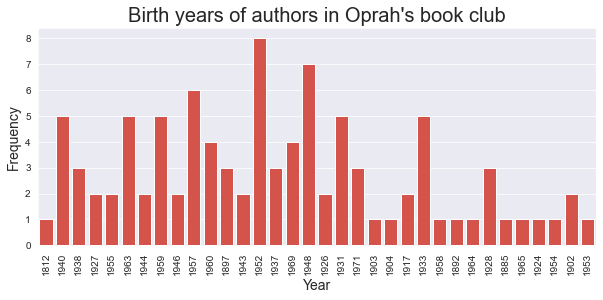

In [142]:
year_count = Counter(birth_years)

x_axis = list(year_count.keys())
y_axis = list(year_count.values())

fig = plt.figure( figsize=( 10 , 4 ) )


graph = sns.barplot( x=x_axis, y=y_axis, color='#eb4034' )

graph.set_title('Birth years of authors in Oprah\'s book club' , size = 20) 
graph.set_xlabel('Year' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )

plt.xticks(rotation= 90)
# The next line places the legend outside out the plot

plt.show()


In [143]:
countries = []
birth_years = []

for book in jenna:
    authors = get_value('authors',book)
    if len(authors)>0:
        author = authors[0]['id']
        countries.append(authors_dict[author][0])
        birth_years.append(authors_dict[author][1])

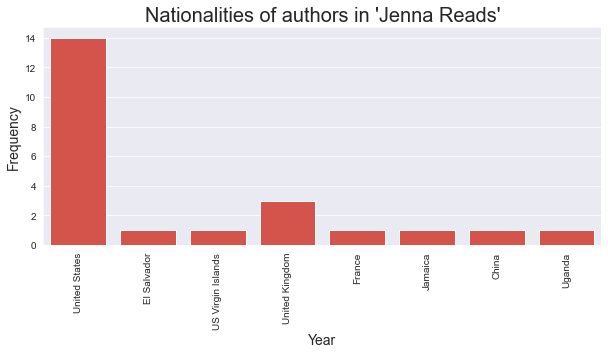

In [145]:
country_count = Counter(countries)
x_axis = list(country_count.keys())
y_axis = list(country_count.values())

fig = plt.figure( figsize=( 10 , 4 ) )


graph = sns.barplot( x=x_axis, y=y_axis, color='#eb4034' )

graph.set_title('Nationalities of authors in \'Jenna Reads\'' , size = 20) 
graph.set_xlabel('Year' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )

plt.xticks(rotation= 90)
# The next line places the legend outside out the plot

plt.show()


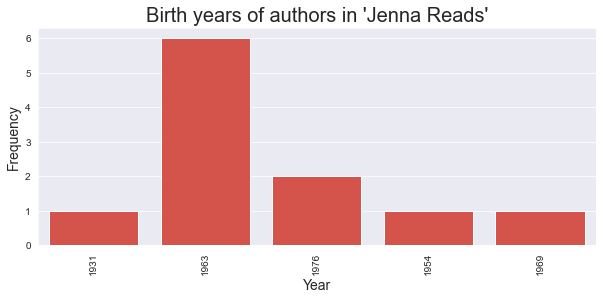

In [146]:
year_count = Counter(birth_years)

x_axis = list(year_count.keys())
y_axis = list(year_count.values())

fig = plt.figure( figsize=( 10 , 4 ) )


graph = sns.barplot( x=x_axis, y=y_axis, color='#eb4034' )

graph.set_title('Birth years of authors in \'Jenna Reads\'' , size = 20) 
graph.set_xlabel('Year' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )

plt.xticks(rotation= 90)
# The next line places the legend outside out the plot

plt.show()


Note that the nationality and the birth date is not provided in all cases in the goodReads database. 